In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import rsciio.digitalmicrograph as dm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import time
from scipy import signal
from concurrent.futures import ThreadPoolExecutor, as_completed

In [ ]:
class NNTrainer:
    def __init__(self, x_data, y_data, edge_onset):
        self.X = x_data.clone() # input data [n_E, 2]
        self.y = y_data.clone() # output data [n_E, n_spectrum]
        self.edge_onset = edge_onset

        self.device = torch.device('cpu') # torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = EELSBackgroundNet().to(self.device)

        self.min_y = torch.min(self.y).item()
        self.max_y = torch.max(self.y).item()
        self.y = (self.y - self.min_y) / (self.max_y - self.min_y) # Normalize y to [0, 1]

        self.min_x1 = torch.min(self.X[:, 0]).item()
        self.max_x1 = torch.max(self.X[:, 0]).item()
        self.min_x2 = torch.min(self.X[:, 1]).item()
        self.max_x2 = torch.max(self.X[:, 1]).item()

        self.X[:, 0] = (self.X[:, 0] - self.min_x1) / (self.max_x1 - self.min_x1) # Normalize energy to [0, 1]
        self.edge_onset_normalized = (self.edge_onset - self.min_x1) / (self.max_x1 - self.min_x1) # Normalize edge onset to [0, 1]
        self.X[:, 1] = (self.X[:, 1] - self.min_x2) / (self.max_x2 - self.min_x2) # Normalize total integrated intensity to [0, 1]

    def loss_function(self, x, y_true, y_pred):
        """Custom loss function for the neural network."""
        # Calculate the mean squared error for all values x less than the edge onset
        mask = x[:, 0] < self.edge_onset_normalized
        y_true = y_true[mask]
        y_pred = y_pred[mask]
        mse_loss = nn.MSELoss()(y_pred, y_true)

        # Here could be some regularization terms

        return mse_loss


    def train(self, epochs=100, lr=0.001):
        """Training method for the neural networks."""
        optimizer = optim.Adam(self.model.parameters(), lr=lr)

        # DataLoader with pin_memory for faster transfer (if using GPU)
        dataset = TensorDataset(self.X, self.y)
        dataloader = DataLoader(dataset, batch_size=100, shuffle=True, pin_memory=True 
                                if self.device.type == "cuda" else False)

        for epoch in range(epochs):
            self.model.train()
            epoch_loss = 0.0
            start_time = time.time()

            for inputs, targets in dataloader:
                inputs = inputs.to(self.device, non_blocking=True)
                targets = targets.to(self.device, non_blocking=True)

                optimizer.zero_grad()
                outputs = self.model(inputs)

                loss = self.loss_function(inputs, outputs.squeeze(), targets)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item() * inputs.size(0)
            if not epoch+1 % 10 or epoch == 1:
                print(f"Epoch [{epoch+1}/{epochs}] - Loss: {epoch_loss:.4f} - Time: {time.time() - start_time:.2f}s")

    def evaluate_model(self, x_eval, effective_exponent_window_size = 3):
        x_eval = x_eval.clone()
        edge_onset_index =  np.abs(x_eval[0,:,0] - self.edge_onset).argmin()
        n_spectrum, n_energy, _ = x_eval.shape

        outputs = torch.zeros((n_spectrum, n_energy), dtype=torch.float32)

        for i in range(n_spectrum):
            x_eval_i = x_eval[i, :, :].reshape(-1, 2)
            energy_unnorm = x_eval[i, :, 0].clone()  # shape: (n_energy,)

            x_eval_i[:, 0] = (x_eval_i[:, 0] - self.min_x1) / (self.max_x1 - self.min_x1)
            x_eval_i[:, 1] = (x_eval_i[:, 1] - self.min_x2) / (self.max_x2 - self.min_x2)
            x_eval_i = x_eval_i.to(self.device)
            x_eval_i.requires_grad_(True)

            self.model.eval()
            outputs_normalized = self.model(x_eval_i)
            outputs_unnormalized = outputs_normalized * (self.max_y - self.min_y) + self.min_y
            
            # Compute gradients for effective exponent region
            gradient = torch.autograd.grad(outputs_normalized.sum(), x_eval_i, retain_graph=True)[0]
            grad_x1 = gradient[edge_onset_index-5:edge_onset_index, 0] #  = d(lnI)'/dE'
            grad_x1 = grad_x1.detach().numpy()
            c_I = self.max_y-self.min_y
            c_E = self.max_x1-self.min_x1
            grad_x1 = grad_x1*c_I/c_E # = dlnI/dE
            grad_x1 = energy_unnorm[edge_onset_index-5:edge_onset_index].numpy() * grad_x1
            effective_exponent = -np.mean(grad_x1)
            print(f"Effective exponent: {effective_exponent:.4f}")
            # Compute power law
                                                    # I = C * (E^-n) => ln(I) = ln(C) - n*ln(E) 
                                                    # with I(E_0) = C * E_0^-n => C = I(E_0) / E_0^-n => ln(C) = ln(I(E_0)) + n*ln(E_0)
            log_C = outputs_unnormalized[edge_onset_index].detach() + effective_exponent * np.log(self.edge_onset)
            energy_for_log = energy_unnorm[edge_onset_index:]
            power_law_log_I = log_C - effective_exponent * torch.log(energy_for_log)

            outputs[i,edge_onset_index:] += power_law_log_I

            # Store pre-edge onset
            outputs[i, :edge_onset_index] += outputs_unnormalized[:edge_onset_index].squeeze()
        return outputs

        # for x_eval_i in x_eval:

        # # Evaluate the model on the training data
        # x_eval_reshaped = x_eval.reshape(-1,2).clone()
        # x_eval_reshaped[:,0] = (x_eval_reshaped[:,0] - self.min_x1) / (self.max_x1 - self.min_x1)

        # x_eval_reshaped[:,1] = (x_eval_reshaped[:,1] - self.min_x2) / (self.max_x2 - self.min_x2)
        # x_eval_reshaped = x_eval_reshaped.to(self.device)

        # with torch.no_grad():
        #     self.model.eval()
        #     outputs_normalized = self.model(x_eval_reshaped)
        #     outputs_normalized = outputs_normalized * (self.max_y - self.min_y) + self.min_y
        #     outputs = outputs_normalized.reshape(x_eval.shape[0], -1)
        # return outputs
        


class EELSBackgroundNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)


In the evaluation, calculating the effective exponents seems weird, but the math comes from conversion between normalized values which the model uses to unnormalized values that we want. We first define the effective exponent as follows:

$$
-r := \frac{\partial\ln{I}}{\partial\ln{E}}
$$

And the normalization operations are:

$$
\ln(I)' = \frac{\ln(I)-\text{min}(\ln(I))}{\text{max}(\ln(I))-\text{min}(\ln(I))} ~~~~| ~~~~ E' = \frac{E-\text{min}(E)}{\text{max}(E)-\text{min}(E)}
$$

The output we get from the autogradient $\texttt{torch.autograd.grad}$ is $\frac{\partial\ln{I'}}{\partial E'}$. Doing some math gives us:

$$
-r = E\frac{c_I}{c_E}\frac{\partial\ln{I'}}{\partial E'}
$$

with c_x equal to the difference between max an min

In [126]:
class NNparameterization:

    def __init__(self):
        self.spatial_axis = None
        self.energy_axis = None
        self.intensity_data = None

        self.clusters = None
        self.clustered_spectra_mean = None
        self.clustered_spectra_std = None

        self.total_integrated_intensity = None

        self.y = None
        self.X_mc = None

        self.X_eval = None

        self.background = None
    def read_dm3(self, path):
        '''Read EELS data from a DM3 file
        
        Parameters
        ----------
        path : str
            Path to the DM3 file
        '''
        raw_data = dm.file_reader(path)
        # Extracting the core loss data
        self.intensity_data = raw_data[0]['data'][:,:]

        # core_loss_data[core_loss_data>4000] = 0

        # Extracting the energy loss axis and spatial axis
        energy_loss_md = raw_data[0]['axes'][1]
        begin, dispersion, size = energy_loss_md['offset'], energy_loss_md['scale'], energy_loss_md['size']
        self.energy_axis = np.linspace(begin, begin + dispersion * (size - 1), size)

        spatial_md = raw_data[0]['axes'][0]
        begin, step, size = spatial_md['offset'], spatial_md['scale'], spatial_md['size']
        self.spatial_axis = np.linspace(begin, begin + step * (size - 1), size)
    
    def align_data(self, reference_spectrum_index = 0):
        '''
        Aligns the core loss data by cross-correlating the data with the reference spectrum
        '''
        shifts = []
        reference_spectrum = self.intensity_data[reference_spectrum_index]
        for i, x in enumerate(self.intensity_data):
            cross_correlate = signal.correlate(x, reference_spectrum, mode='full')
            shift = len(x) - np.argmax(cross_correlate)
            self.intensity_data[i] = np.roll(x, shift)
            shifts.append(shift)

        #window data such that all spectra starts/ends at the same energy loss
        self.window_data(lower = self.energy_axis[max(shifts)], 
                         higher = self.energy_axis[min(shifts)] if min(shifts)<0 else  1e6)
                
    def window_data(self, lower=0, higher=1e6):
        '''
        Windows the core loss data to a specific energy loss range
        '''
        window = (self.energy_axis<higher)&(self.energy_axis>lower)
        self.intensity_data = self.intensity_data[:,window]
        self.energy_axis = self.energy_axis[window]

    def plot_spectra(self, spectra_indices=None):
        '''
        Plots the core loss data for the specified spectra indices
        '''
        if spectra_indices is None:
            spectra_indices = range(self.intensity_data.shape[0])
        plt.figure(figsize=(10, 6))
        for i in spectra_indices:
            plt.plot(self.energy_axis, self.intensity_data[i], label=f'Spectrum {i}')
        plt.xlabel('Energy Loss (eV)')
        plt.ylabel('Intensity (a.u.)')
        plt.title('Core Loss Spectra')
        plt.legend()
        plt.show()

    def calculate_integrated_intensity(self):
        self.total_integrated_intensity = np.sum(self.intensity_data, axis=1) # shape [n_spectrum]

    def cluster_data(self, n_clusters):
        kmeans = KMeans(n_clusters=n_clusters)
        clusters = kmeans.fit_predict(self.total_integrated_intensity.reshape(-1, 1))
        self.clustered_spectra_mean = np.zeros((len(self.energy_axis), n_clusters))
        self.clustered_spectra_std = np.zeros((len(self.energy_axis), n_clusters))
        self.clustered_spectra_centers = kmeans.cluster_centers_
        for i in range(n_clusters):
            self.clustered_spectra_mean[:, i] = np.mean(self.intensity_data[:][clusters == i], axis=0)
            self.clustered_spectra_std[:, i] = np.std(self.intensity_data[:][clusters == i], axis=0) 

    def prepare_X_mc_data(self):
        
        num_energy_loss, num_clusters = self.clustered_spectra_mean.shape

        # normalized_energy_axis = np.linspace(0, 1, num_energy_loss) # shape [n_E]
        energy_axis_expanded = torch.Tensor(self.energy_axis).unsqueeze(0).expand(num_clusters, -1) # shape [num_clusters, n_E]

        clustered_spectra_centers = torch.Tensor(self.clustered_spectra_centers).squeeze()  # Remove extra dimensions if any
        clustered_spectra_centers_expanded = torch.log(clustered_spectra_centers.unsqueeze(1).expand(-1, num_energy_loss))  # shape [num_clusters, n_E]

        X_mc = torch.stack([
            energy_axis_expanded, 
            clustered_spectra_centers_expanded
        ], dim=2)

        self.X_mc = X_mc.reshape(-1, 2) # shape [n_cluster*n_E, 2]

    def prepare_X_eval_data(self):
        num_spectra, num_energy_loss = self.intensity_data.shape

        # energy_axis = np.linspace(0, 1, num_energy_loss) # shape [n_E]
        energy_axis_expanded = torch.Tensor(self.energy_axis).unsqueeze(0).expand(num_spectra, -1)
        total_integrated_intensity_expanded = torch.log(torch.Tensor(self.total_integrated_intensity).unsqueeze(1).expand(-1, num_energy_loss))
        X_eval = torch.stack([
            energy_axis_expanded, 
            total_integrated_intensity_expanded
        ], dim=2)

        self.X_eval = X_eval

    def train_MC_replica_consecutive(self, n_mc_replicas, edge_onset = 0):
        self.background_mean = np.zeros_like(self.intensity_data)
        self.background_std = np.zeros_like(self.intensity_data)
        self.background = np.zeros((n_mc_replicas, self.intensity_data.shape[0], self.intensity_data.shape[1])) # shape [n_mc_replicas, n_spectrum, n_E]
        for i in range(n_mc_replicas):
            mc_replica = np.log(np.random.normal(self.clustered_spectra_mean,
                                          self.clustered_spectra_std )) # shape [n_E, n_clusters]
            plt.plot(mc_replica, color = ['red', 'blue'][i%2], alpha = 0.5)
            if np.any(mc_replica <= 0):
                print("Warning: log input has non-positive values")
            y = torch.Tensor(mc_replica.T).reshape(-1) # shape [n_clusters*n_E]
            NN_object = NNTrainer(self.X_mc, y, edge_onset)
            NN_object.train()

            self.background[i] = np.exp(NN_object.evaluate_model(self.X_eval).squeeze(-1).detach().numpy()) #shape [n_spectrum, n_E]

    def train_MC_replica_parallel(self, n_mc_replicas, edge_onset = 0):
        self.background_mean = np.zeros_like(self.intensity_data)
        self.background_std = np.zeros_like(self.intensity_data)
        self.background = np.zeros((n_mc_replicas, self.intensity_data.shape[0], self.intensity_data.shape[1]))

        def run(i):
            mc_sample = np.random.normal(self.clustered_spectra_mean, self.clustered_spectra_std)
            if np.any(mc_sample <= 0):
                print(f"Warning in replica {i}: non-positive values")
            mc_replica = np.log(mc_sample)
            y = torch.tensor(mc_replica.T.astype(np.float32)).reshape(-1)

            NN_object = NNTrainer(self.X_mc, y, edge_onset)
            NN_object.train()
            background_i = np.exp(NN_object.evaluate_model(self.X_eval).squeeze(-1))
            return i, background_i

        with ThreadPoolExecutor(max_workers=10) as executor:  # Adjust worker count as needed
            futures = [executor.submit(run, i) for i in range(n_mc_replicas)]

            for future in as_completed(futures):
                i, result = future.result()
                self.background[i] = result


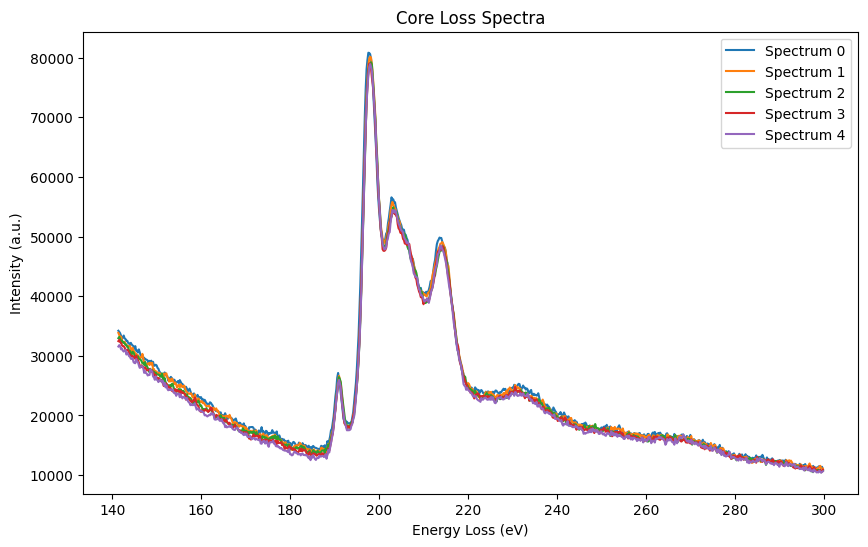

Epoch [1/100] - Loss: 162.0465 - Time: 0.12s
Epoch [11/100] - Loss: 12.2353 - Time: 0.11s
Epoch [21/100] - Loss: 9.8910 - Time: 0.11s
Epoch [31/100] - Loss: 9.4886 - Time: 0.12s
Epoch [41/100] - Loss: 9.4654 - Time: 0.11s
Epoch [51/100] - Loss: 9.3214 - Time: 0.11s
Epoch [61/100] - Loss: 8.1572 - Time: 0.11s
Epoch [71/100] - Loss: 8.0421 - Time: 0.11s
Epoch [81/100] - Loss: 7.9191 - Time: 0.11s
Epoch [91/100] - Loss: 8.0984 - Time: 0.11s


C:\Users\bartv\AppData\Local\Temp\ipykernel_3028\474729452.py:67: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  edge_onset_index =  np.abs(x_eval[0,:,0] - self.edge_onset).argmin()


Effective exponent: 0.8809
tensor([14.2583])
tensor([9.6453, 9.6444, 9.6435, 9.6425, 9.6416, 9.6407, 9.6397, 9.6388, 9.6379,
        9.6369, 9.6360, 9.6351, 9.6342, 9.6332, 9.6323, 9.6314, 9.6305, 9.6295,
        9.6286, 9.6277, 9.6268, 9.6259, 9.6249, 9.6240, 9.6231, 9.6222, 9.6213,
        9.6204, 9.6195, 9.6186, 9.6177, 9.6167, 9.6158, 9.6149, 9.6140, 9.6131,
        9.6122, 9.6113, 9.6104, 9.6095, 9.6086, 9.6077, 9.6068, 9.6059, 9.6050,
        9.6041, 9.6032, 9.6023, 9.6015, 9.6006, 9.5997, 9.5988, 9.5979, 9.5970,
        9.5961, 9.5952, 9.5944, 9.5935, 9.5926, 9.5917, 9.5908, 9.5899, 9.5891,
        9.5882, 9.5873, 9.5864, 9.5856, 9.5847, 9.5838, 9.5829, 9.5821, 9.5812,
        9.5803, 9.5794, 9.5786, 9.5777, 9.5768, 9.5760, 9.5751, 9.5742, 9.5734,
        9.5725, 9.5716, 9.5708, 9.5699, 9.5691, 9.5682, 9.5674, 9.5665, 9.5656,
        9.5648, 9.5639, 9.5631, 9.5622, 9.5614, 9.5605, 9.5597, 9.5588, 9.5580,
        9.5571, 9.5563, 9.5554, 9.5546, 9.5537, 9.5529, 9.5520, 9.5512, 9.5

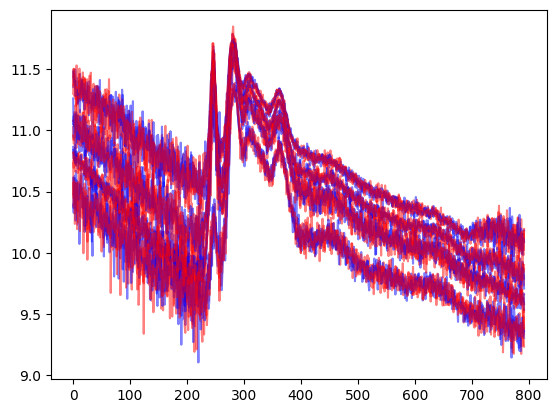

In [127]:
path_to_data = "../Data/008_core_loss_line_020evpx_1mm.dm3"
objectNN = NNparameterization()
objectNN.read_dm3(path_to_data)
objectNN.align_data()
objectNN.window_data(lower=0, higher=300)
objectNN.plot_spectra(spectra_indices=[0, 1, 2, 3, 4])
objectNN.calculate_integrated_intensity()
objectNN.cluster_data(n_clusters=4)
objectNN.prepare_X_mc_data()
objectNN.prepare_X_eval_data()
objectNN.train_MC_replica_consecutive(n_mc_replicas=5, edge_onset=188)

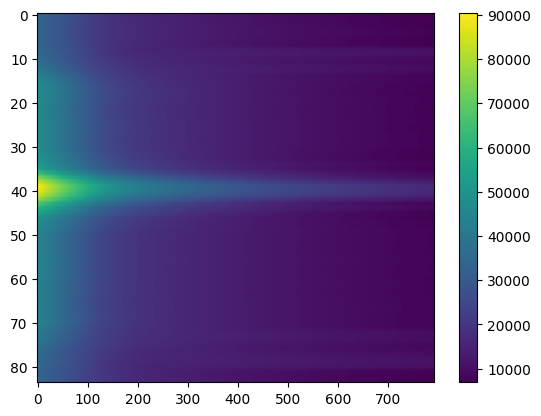

(5, 84, 793)


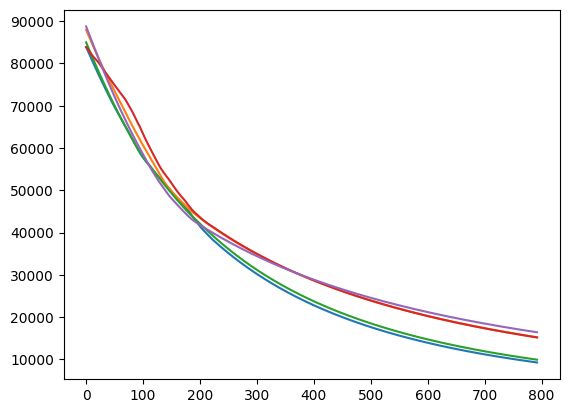

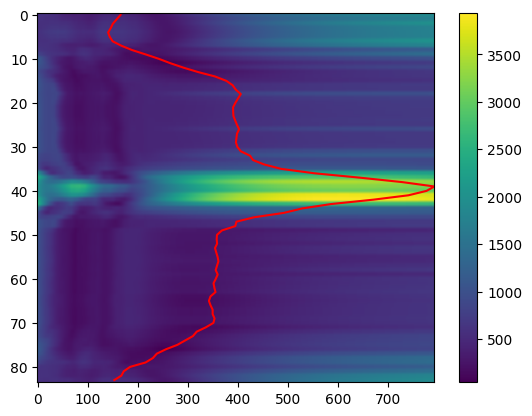

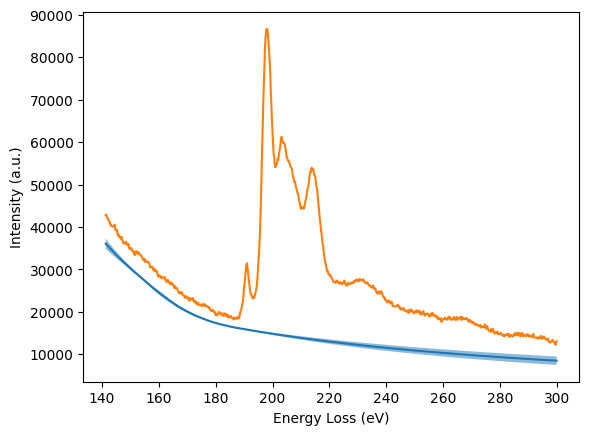

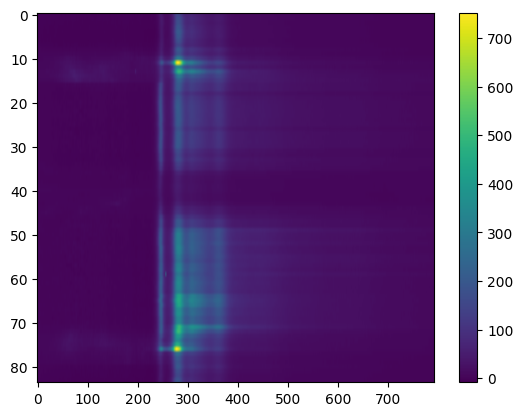

In [128]:
# objectNN.background,0)
plt.imshow(np.nan_to_num(objectNN.background[4]), aspect='auto', cmap='viridis')
plt.colorbar()
plt.show()
print(objectNN.background.shape)
bgmean = np.mean(objectNN.background, axis=0)
bgstd = np.std(objectNN.background, axis=0)

plt.plot(objectNN.background[:,40,:].T)
# plt.plot(objectNN.intensity_data.T, alpha=0.5)
# plt.colorbar()
# plt.plot(objectNN.background[0])
# print(objectNN.background[1]-objectNN.background[0])
# plt.imshow(bgmean, aspect='auto', cmap='viridis')
# plt.colorbar()
plt.show()
tii = objectNN.total_integrated_intensity
frac = 0.7
plt.plot((tii-frac*min(tii))/(max(tii)-min(tii)*frac)*len(objectNN.energy_axis), range(len(objectNN.spatial_axis)), color='red')
plt.imshow(bgstd, aspect='auto', cmap='viridis')
plt.colorbar()
plt.show()


show_spectrum = 10
plt.plot(objectNN.energy_axis, bgmean[show_spectrum], label='Mean Background')
plt.fill_between(objectNN.energy_axis, bgmean[show_spectrum]-bgstd[show_spectrum], bgmean[show_spectrum]+bgstd[show_spectrum], alpha=0.5, label='1 Std Dev')
plt.plot(objectNN.energy_axis, objectNN.intensity_data[show_spectrum], label='Spectrum 40')
plt.xlabel('Energy Loss (eV)')
plt.ylabel('Intensity (a.u.)')
plt.show()

plt.imshow((objectNN.intensity_data-bgmean)/bgstd, aspect='auto', cmap='viridis')
plt.colorbar()
plt.show()